# Cliente del centro comercial (hierarchical clustering)



### 1.Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.

In [3]:
# Importar las librerias
import numpy as np 
import pandas as pd 
from pandas import plotting
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score,  calinski_harabasz_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importar el dataset
dataset = pd.read_csv('Mall_Customers.csv') 

In [5]:
dataset.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# Estadísticas descriptivas
print(dataset.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


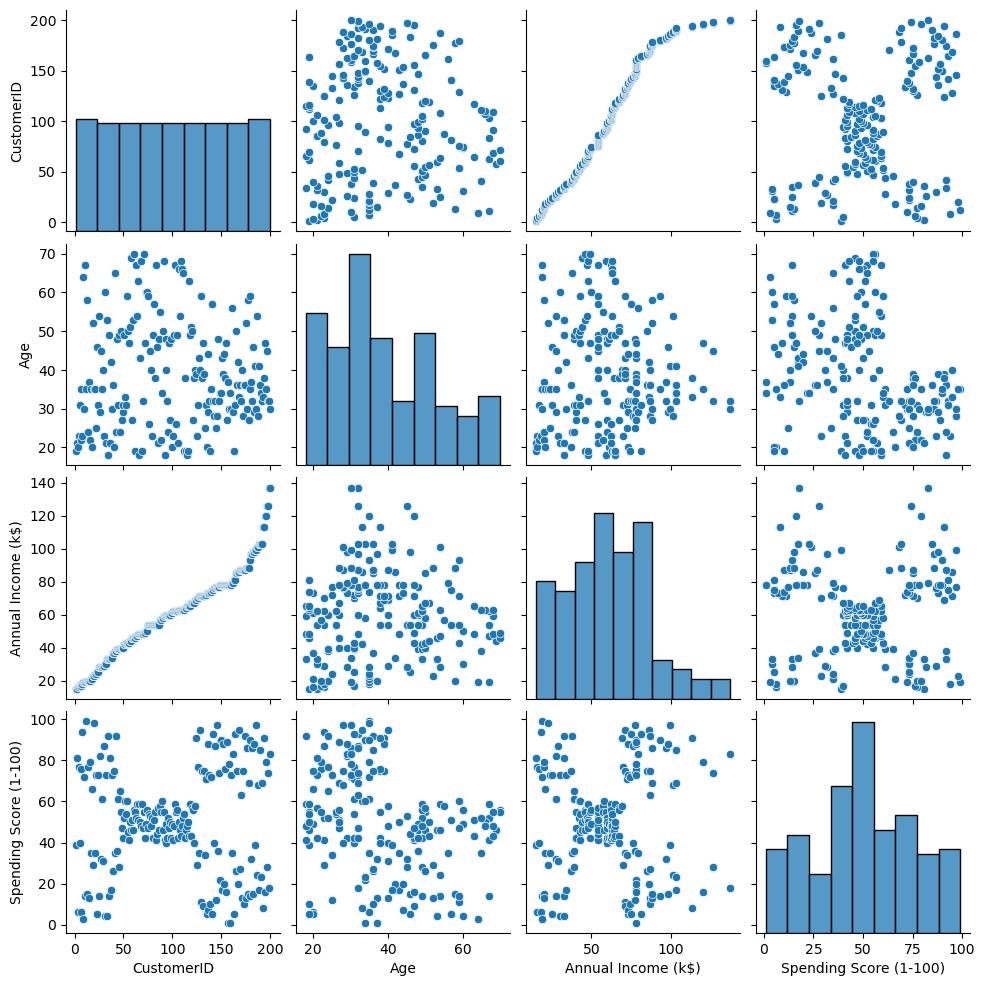

In [14]:
# Visualización de distribución de las variables
sns.pairplot(dataset)
plt.show()

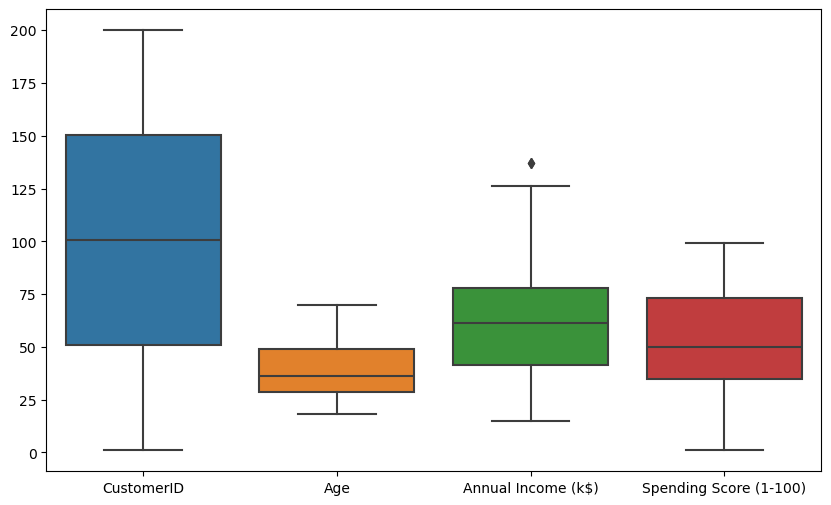

In [8]:
# Diagrama de caja para identificar valores atípicos
plt.figure(figsize=(10,6))
sns.boxplot(data=dataset)
plt.show()

In [9]:
# Mostrar la matriz de correlación
numeric_columns = dataset.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()
print(corr_matrix)

                        CustomerID       Age  Annual Income (k$)  \
CustomerID                1.000000 -0.026763            0.977548   
Age                      -0.026763  1.000000           -0.012398   
Annual Income (k$)        0.977548 -0.012398            1.000000   
Spending Score (1-100)    0.013835 -0.327227            0.009903   

                        Spending Score (1-100)  
CustomerID                            0.013835  
Age                                  -0.327227  
Annual Income (k$)                    0.009903  
Spending Score (1-100)                1.000000  


In [16]:
# Paso 1: Identificar valores faltantes
missing_values = dataset.isnull().sum()
print("Valores faltantes:\n", missing_values)

Valores faltantes:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


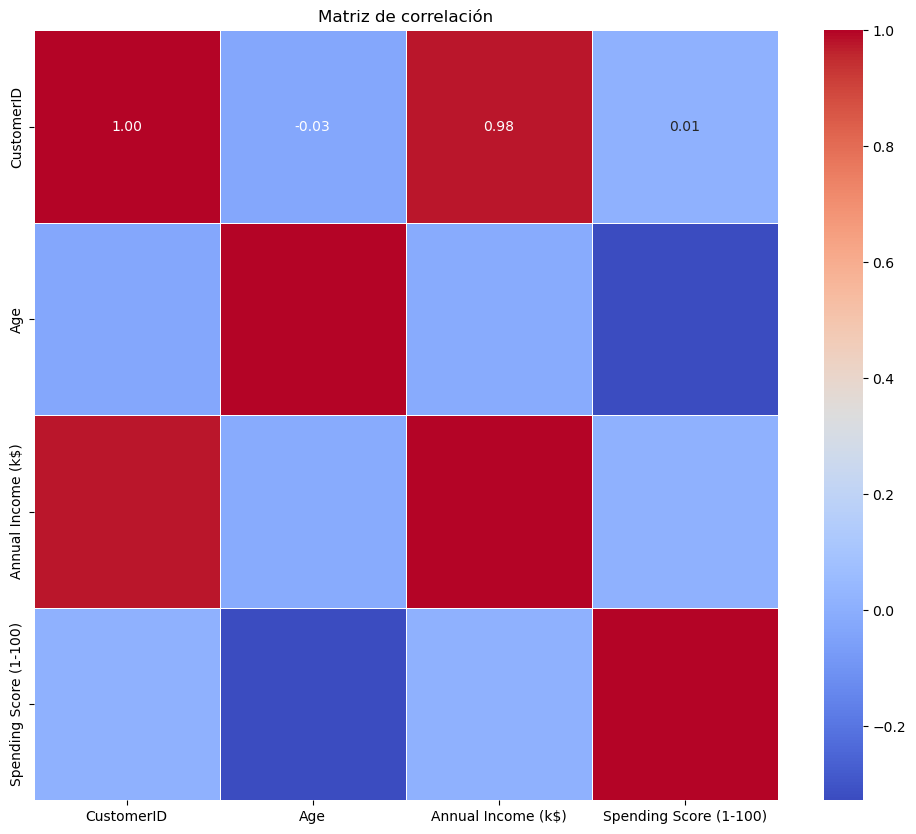

In [20]:
# Matriz de correlacion en diagrama
numeric_columns = dataset.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)
scaled_dataset = pd.DataFrame(scaled_data, columns=numeric_columns.columns)
corr_matrix = scaled_dataset.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

### 2.Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario.

In [21]:
dataset['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

In [22]:
dataset.groupby('Gender').mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,,
Female,97.562500,38.098214,59.250000,51.526786
Male,104.238636,39.806818,62.227273,48.511364


In [23]:
# Comprobación de valores faltantes
missing_df =dataset.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Values Count']
missing_df['Filling Factor (%)']=(dataset.shape[0]-missing_df['Missing Values Count'])/dataset.shape[0]*100
missing_df.sort_values('Filling Factor (%)').reset_index(drop = True)

,Column Name,Missing Values Count,Filling Factor (%)
0,CustomerID,0,100.0
1,Gender,0,100.0
2,Age,0,100.0
3,Annual Income (k$),0,100.0
4,Spending Score (1-100),0,100.0


In [24]:
# Importar las funciones necesarias para preprocesar los datos
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
scaler = StandardScaler()



In [25]:
# Normalizar los datos numéricos
numeric_columns_normalized = scaler.fit_transform(dataset[numeric_columns.columns])

# Convertir el resultado de la normalización en un DataFrame
dataset[numeric_columns.columns] = numeric_columns_normalized

# Mostrar las primeras filas del DataFrame preprocesado
print("DataFrame preprocesado:\n", dataset.head())

DataFrame preprocesado:
    CustomerID  Gender       Age  Annual Income (k$)  Spending Score (1-100)
0   -1.723412    Male -1.424569           -1.738999               -0.434801
1   -1.706091    Male -1.281035           -1.738999                1.195704
2   -1.688771  Female -1.352802           -1.700830               -1.715913
3   -1.671450  Female -1.137502           -1.700830                1.040418
4   -1.654129  Female -0.563369           -1.662660               -0.395980


## 3. hierarchical clustering

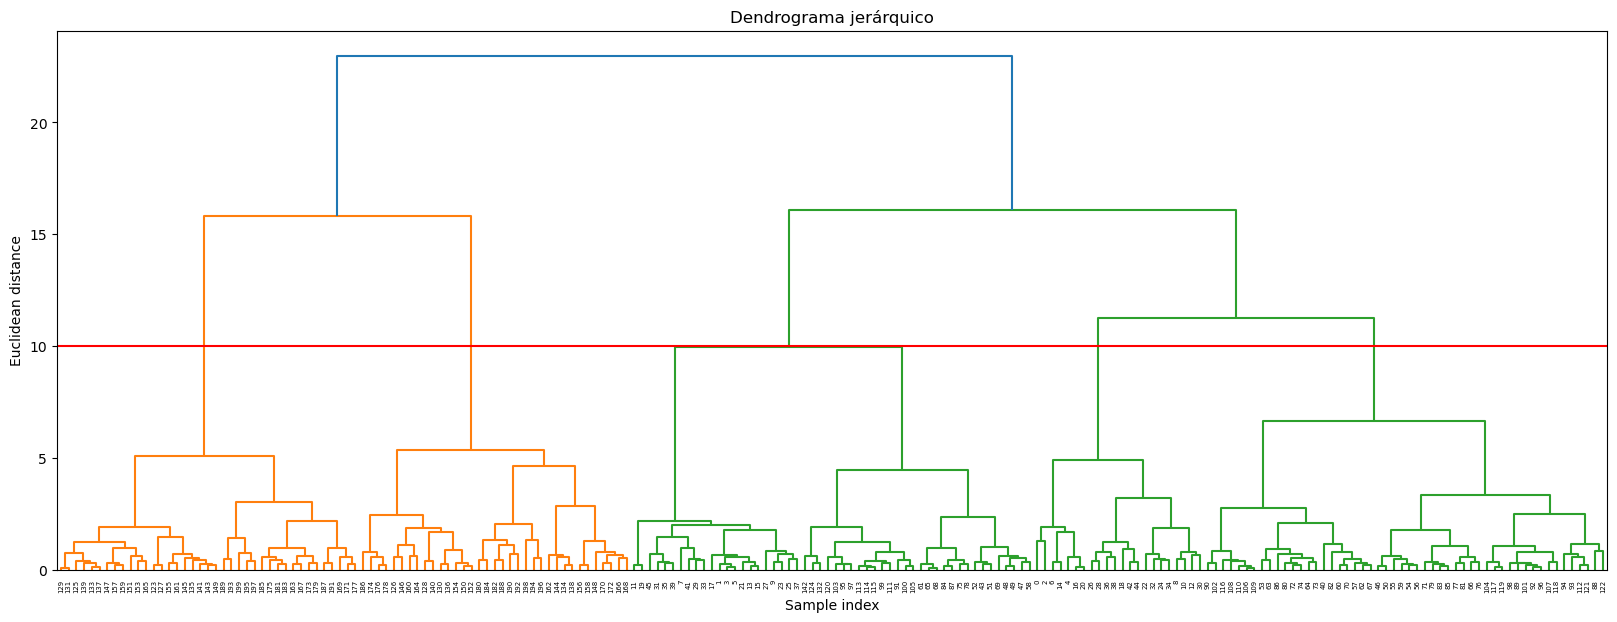

In [31]:
# Eliminar las columnas no numéricas o transformarlas a variables numéricas
numeric_dataset = dataset.select_dtypes(include=['float64', 'int64'])
# Calcular la matriz de enlace utilizando el método de Ward y métrica euclidiana
Z = linkage(numeric_dataset, method='ward', metric='euclidean')
# Visualizar el dendrograma
plt.figure(figsize=(20, 7))
dendrogram(Z)
plt.axhline(y=10,color = 'r', linestyle = '-')
plt.title('Dendrograma jerárquico')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

In [49]:
numeric_dataset = dataset.select_dtypes(include=['float64', 'int64'])
# Crear una instancia del modelo AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5, linkage='ward', affinity='euclidean')
labels_hier = model.fit_predict(numeric_dataset) 
labels_hier

array([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
       4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 2, 0, 4, 0,
       4, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3,
       0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3], dtype=int64)

In [50]:
# Eliminar las columnas no numéricas o transformarlas a variables numéricas
numeric_dataset = dataset.select_dtypes(include=['float64', 'int64'])


In [52]:
# obtener las etiquetas de cada puntos de nuestros datos
labels = labels_hier
colores = ['red', 'blue', 'cyan', 'green', 'pink']
asignar = []
for row in labels:
    asignar.append(colores[row])

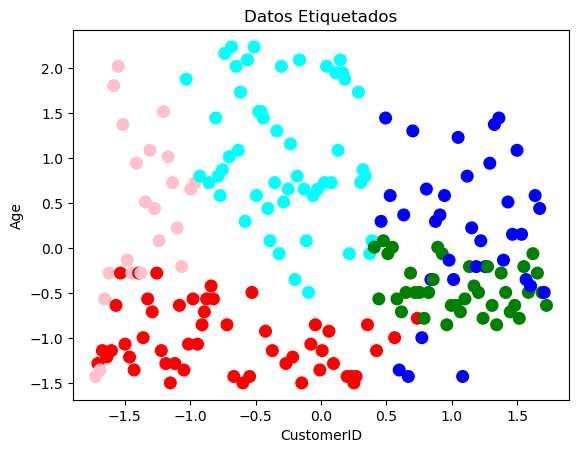

In [55]:
f1 = numeric_dataset['CustomerID'].values
f2 = numeric_dataset['Age'].values
plt.scatter(f1,f2,c=asignar, s=70)
plt.title ('Datos Etiquetados')
plt.xlabel ('CustomerID')
plt.ylabel ('Age')
plt.show()

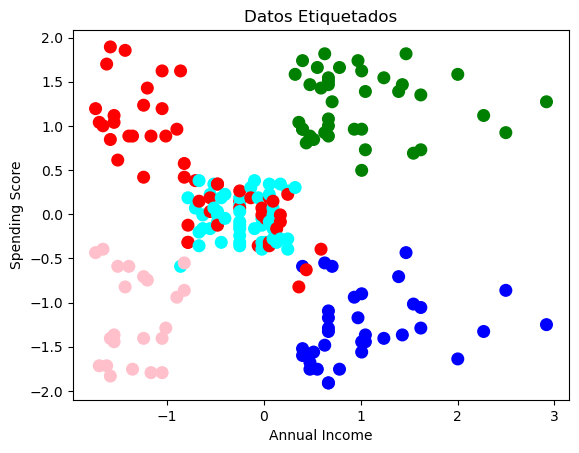

In [58]:
f1 = numeric_dataset['Annual Income (k$)'].values
f2 = numeric_dataset['Spending Score (1-100)'].values
plt.scatter(f1,f2,c=asignar, s=70)
plt.title ('Datos Etiquetados')
plt.xlabel ('Annual Income')
plt.ylabel ('Spending Score')
plt.show()

In [63]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
# Eliminar la columna de sexo del dataset
dataset_sin_sexo = dataset.drop(columns=['Gender'])



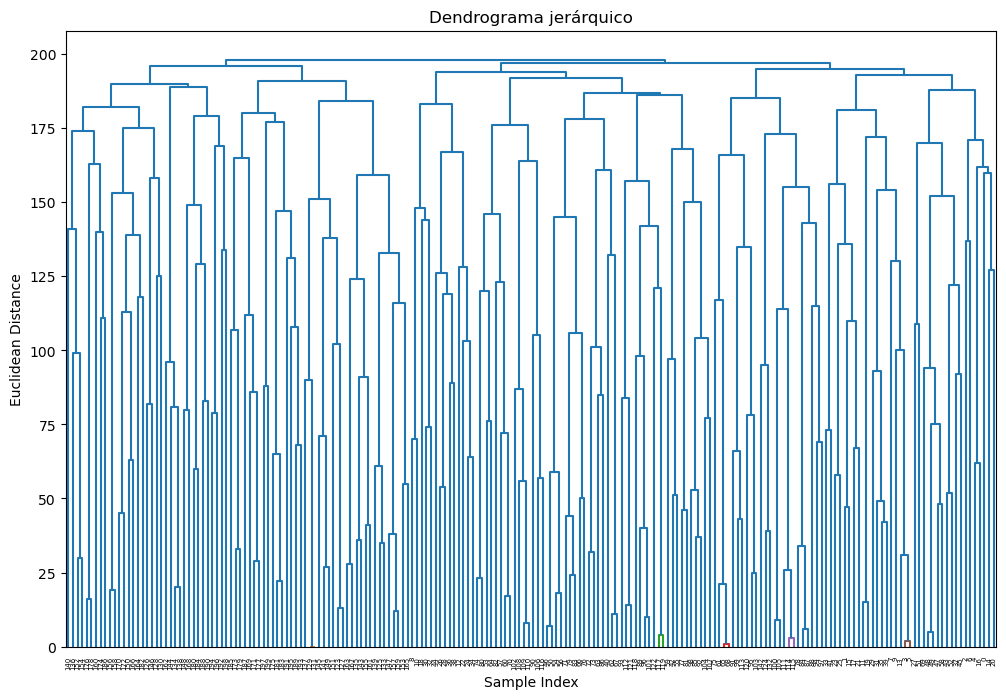

In [70]:
# Codificar la variable categórica "Gender" en variables numéricas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['Gender'] = label_encoder.fit_transform(dataset['Gender'])

# Eliminar la columna de sexo del dataset
dataset_sin_sexo = dataset.drop(columns=['Gender'])
def plot_dendrogram(model, **kwargs):
    """
    Función para visualizar un dendrograma dado un modelo de clustering jerárquico.

    Argumentos:
    - model: El modelo de clustering jerárquico ajustado.
    - **kwargs: Otros argumentos opcionales que se pueden pasar a la función dendrogram.
    """
    # Obtener la matriz de enlace del modelo
    if not hasattr(model, 'children_'):
        raise TypeError("El modelo no es un modelo de clustering jerárquico válido.")
    children = model.children_

    # Calcular las distancias entre las muestras
    distance = np.arange(children.shape[0])

    # Crear la matriz de enlace
    linkage_matrix = np.column_stack([children, distance, distance]).astype(float)

    # Visualizar el dendrograma
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(12, 8))
plot_dendrogram(model, color_threshold=5)
plt.title('Dendrograma jerárquico')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

## Desempeño del modelo con métricas como 
Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc

Para k = 2, el coeficiente de Silhouette es 0.28856600012427774
Para k = 3, el coeficiente de Silhouette es 0.29383226368661186
Para k = 4, el coeficiente de Silhouette es 0.36487294361658884
Para k = 5, el coeficiente de Silhouette es 0.34006722676994466
Para k = 6, el coeficiente de Silhouette es 0.3398429230662927
Para k = 7, el coeficiente de Silhouette es 0.3424185957614415
Para k = 8, el coeficiente de Silhouette es 0.32138689672547954
Para k = 9, el coeficiente de Silhouette es 0.29151464957865153
Para k = 10, el coeficiente de Silhouette es 0.27874961608232796


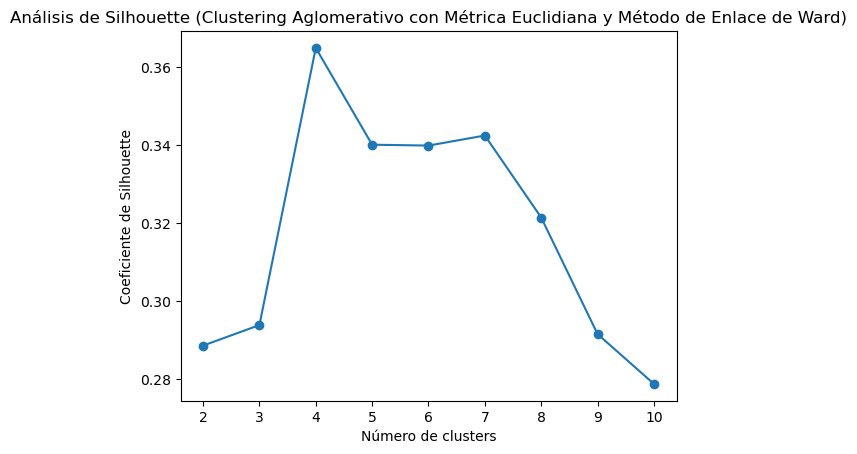

In [73]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def silhouette_analysis_agglomerative(data, max_clusters):
    """
    Realiza un análisis de Silhouette para identificar el número óptimo de clusters usando clustering aglomerativo con
    la métrica de distancia euclidiana y el método de enlace de Ward.

    Argumentos:
    - data: Los datos sobre los que se realizará el análisis de Silhouette.
    - max_clusters: El número máximo de clusters a considerar.

    Retorna:
    - Una lista con los valores de coeficiente de Silhouette para cada número de clusters.
    """
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        # Inicializar y ajustar el modelo de clustering aglomerativo con métrica euclidiana y método de enlace de Ward
        agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
        cluster_labels = agglomerative.fit_predict(data)

        # Calcular el coeficiente de Silhouette
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print(f"Para k = {k}, el coeficiente de Silhouette es {silhouette_avg}")

    return silhouette_scores

# Ejemplo de uso:
max_clusters = 10  # Especifica el número máximo de clusters a considerar
silhouette_scores = silhouette_analysis_agglomerative(dataset, max_clusters)

# Visualizar los resultados
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Análisis de Silhouette (Clustering Aglomerativo con Métrica Euclidiana y Método de Enlace de Ward)')
plt.show()

## Medidas de Calidad 

In [74]:
# Calcular medidas de calidad para Clustering Jerárquico 
print("\nMedidas de calidad para Clustering Jerárgico:")
print("Puntaje de silueta: ", metrics.silhouette_score(numeric_dataset, labels_hier))
print("Índice de Calinski-Harabasz:", metrics.calinski_harabasz_score(numeric_dataset, labels_hier))
print("Davies-Bouldin Index:", metrics.davies_bouldin_score(numeric_dataset, labels_hier))


Medidas de calidad para Clustering Jerárgico:
Puntaje de silueta:  0.3261570612521571
Índice de Calinski-Harabasz: 101.68771582847572
Davies-Bouldin Index: 1.075502328315164


In [78]:
# Calcular coeficiente de correlación cofenética
from scipy.cluster.hierarchy import linkage 
# Calcular las distancias euclidianas entre pares de puntos
Dist = pdist(numeric_dataset)
# Compute the linkage matrix
Z = linkage(numeric_dataset, "ward")
# Calcule el Cophenetic correlation coefficiente
Coef = cophenet(Z, Dist)
print("Coeficiente de correlación cofenética: ", Coef)



Coeficiente de correlación cofenética:  (0.644982688580315, array([16.06037879,  1.28415501, 16.06037879, ..., 15.79117249,
        0.74388365, 15.79117249]))


## Comparar con otro Cluster # 4

In [80]:
numeric_dataset = dataset.select_dtypes(include=['float64', 'int64'])
# Crear una instancia del modelo AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean')
labels_hier = model.fit_predict(numeric_dataset) 
labels_hier

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 3, 1, 3, 1, 3, 1,
       0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1], dtype=int64)

In [89]:
# Eliminar las columnas no numéricas o transformarlas a variables numéricas
X = dataset.select_dtypes(include=['float64', 'int64'])
# obtener las etiquetas de cada puntos de nuestros datos
labels = labels_hier
colores = ['red', 'blue','green', 'pink']
asignar = []
for row in labels:
    asignar.append(colores[row])

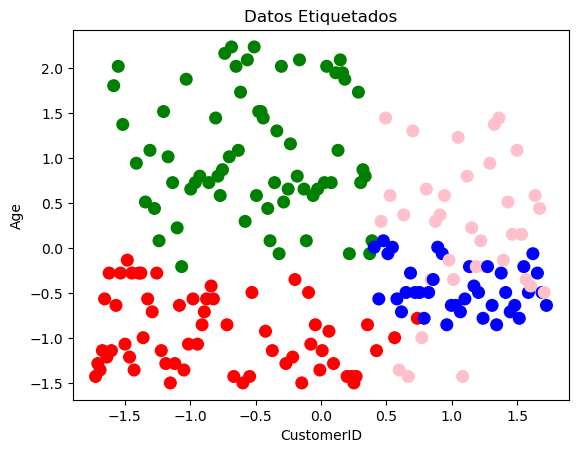

In [90]:
f1 = X['CustomerID'].values
f2 = X['Age'].values
plt.scatter(f1,f2,c=asignar, s=70)
plt.title ('Datos Etiquetados')
plt.xlabel ('CustomerID')
plt.ylabel ('Age')
plt.show()

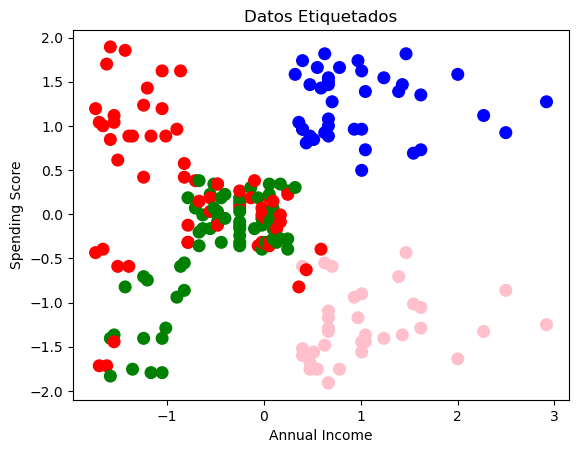

In [91]:
f1 = X['Annual Income (k$)'].values
f2 = X['Spending Score (1-100)'].values
plt.scatter(f1,f2,c=asignar, s=70)
plt.title ('Datos Etiquetados')
plt.xlabel ('Annual Income')
plt.ylabel ('Spending Score')
plt.show()

In [84]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
# Eliminar la columna de sexo del dataset
dataset_sin_sexo = dataset.drop(columns=['Gender'])

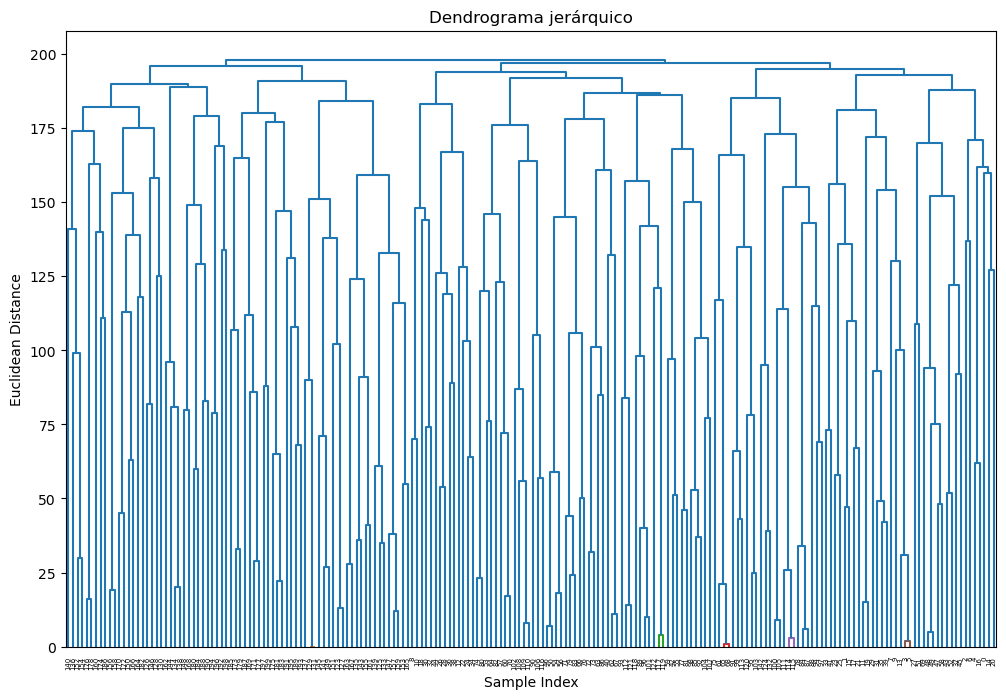

In [85]:
# Codificar la variable categórica "Gender" en variables numéricas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['Gender'] = label_encoder.fit_transform(dataset['Gender'])

# Eliminar la columna de sexo del dataset
dataset_sin_sexo = dataset.drop(columns=['Gender'])
def plot_dendrogram(model, **kwargs):
    """
    Función para visualizar un dendrograma dado un modelo de clustering jerárquico.

    Argumentos:
    - model: El modelo de clustering jerárquico ajustado.
    - **kwargs: Otros argumentos opcionales que se pueden pasar a la función dendrogram.
    """
    # Obtener la matriz de enlace del modelo
    if not hasattr(model, 'children_'):
        raise TypeError("El modelo no es un modelo de clustering jerárquico válido.")
    children = model.children_

    # Calcular las distancias entre las muestras
    distance = np.arange(children.shape[0])

    # Crear la matriz de enlace
    linkage_matrix = np.column_stack([children, distance, distance]).astype(float)

    # Visualizar el dendrograma
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(12, 8))
plot_dendrogram(model, color_threshold=5)
plt.title('Dendrograma jerárquico')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

Para k = 2, el coeficiente de Silhouette es 0.28856600012427774
Para k = 3, el coeficiente de Silhouette es 0.29383226368661186
Para k = 4, el coeficiente de Silhouette es 0.36487294361658884
Para k = 5, el coeficiente de Silhouette es 0.34006722676994466
Para k = 6, el coeficiente de Silhouette es 0.3398429230662927
Para k = 7, el coeficiente de Silhouette es 0.3424185957614415
Para k = 8, el coeficiente de Silhouette es 0.32138689672547954
Para k = 9, el coeficiente de Silhouette es 0.29151464957865153
Para k = 10, el coeficiente de Silhouette es 0.27874961608232796


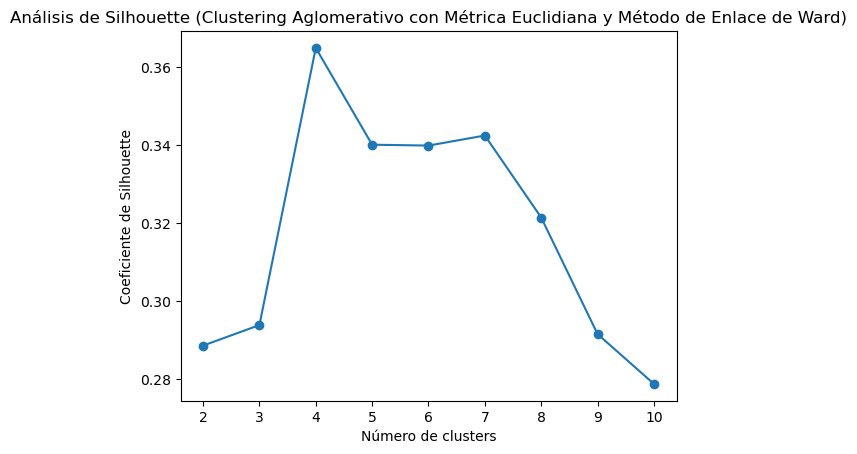

In [86]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def silhouette_analysis_agglomerative(data, max_clusters):
    """
    Realiza un análisis de Silhouette para identificar el número óptimo de clusters usando clustering aglomerativo con
    la métrica de distancia euclidiana y el método de enlace de Ward.

    Argumentos:
    - data: Los datos sobre los que se realizará el análisis de Silhouette.
    - max_clusters: El número máximo de clusters a considerar.

    Retorna:
    - Una lista con los valores de coeficiente de Silhouette para cada número de clusters.
    """
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        # Inicializar y ajustar el modelo de clustering aglomerativo con métrica euclidiana y método de enlace de Ward
        agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
        cluster_labels = agglomerative.fit_predict(data)

        # Calcular el coeficiente de Silhouette
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print(f"Para k = {k}, el coeficiente de Silhouette es {silhouette_avg}")

    return silhouette_scores

# Ejemplo de uso:
max_clusters = 10  # Especifica el número máximo de clusters a considerar
silhouette_scores = silhouette_analysis_agglomerative(dataset, max_clusters)

# Visualizar los resultados
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Análisis de Silhouette (Clustering Aglomerativo con Métrica Euclidiana y Método de Enlace de Ward)')
plt.show()

In [92]:
# Calcular medidas de calidad para Clustering Jerárquico 
print("\nMedidas de calidad para Clustering Jerárgico:")
print("Puntaje de silueta: ", metrics.silhouette_score(X, labels_hier))
print("Índice de Calinski-Harabasz:", metrics.calinski_harabasz_score(X, labels_hier))
print("Davies-Bouldin Index:", metrics.davies_bouldin_score(X, labels_hier))


Medidas de calidad para Clustering Jerárgico:
Puntaje de silueta:  0.36487294361658884
Índice de Calinski-Harabasz: 109.52236041935463
Davies-Bouldin Index: 1.0302829551152048


In [94]:
# Calcular coeficiente de correlación cofenética
from scipy.cluster.hierarchy import linkage 
# Calcular las distancias euclidianas entre pares de puntos
Dist2 = pdist(X)
# Compute the linkage matrix
Y = linkage(X, "ward")
# Calcule el Cophenetic correlation coefficiente
Coefi = cophenet(Y, Dist2)
print("Coeficiente de correlación cofenética: ", Coefi)


Coeficiente de correlación cofenética:  (0.6336347771351108, array([ 6.80964144,  2.07777385,  6.80964144, ..., 15.80527219,
        0.56583001, 15.80527219]))
